<h1 align="center"> <strong>⚡ LightGBM - Complete Guide</strong> </h1>

This notebook provides a comprehensive introduction to LightGBM (Light Gradient Boosting Machine), covering:
- Algorithm overview and key concepts
- LightGBM's innovations and advantages
- Implementation using the LightGBM library
- Hyperparameter tuning
- Feature importance visualization
- Best practices and use cases

---

## **📚 1. Import Libraries and Setup**

In [2]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

# Machine learning
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, roc_curve, auc,
    mean_squared_error, r2_score, mean_absolute_error
)

# LightGBM
import lightgbm as lgb
from lightgbm import LGBMClassifier, LGBMRegressor, plot_importance, plot_tree, plot_metric

# For comparison
import xgboost as xgb
from xgboost import XGBClassifier

# Visualization settings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (10, 6)

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ Libraries imported successfully!")

✅ Libraries imported successfully!


## **⚡ 2. LightGBM Algorithm Overview**

LightGBM (Light Gradient Boosting Machine) is a gradient boosting framework developed by Microsoft that uses tree-based learning algorithms. It was designed for distributed and efficient training and has gained popularity for its speed and performance.

### **Key Concepts and Innovations**

LightGBM introduces several key innovations that distinguish it from other gradient boosting frameworks:

1. **Gradient-based One-Side Sampling (GOSS)**
   - Focuses on instances with larger gradients (more important for training)
   - Reduces data size without losing accuracy

2. **Exclusive Feature Bundling (EFB)**
   - Bundles mutually exclusive features (rarely take non-zero values simultaneously)
   - Reduces feature dimensionality without losing information
   
3. **Leaf-wise (Best-first) Tree Growth**
   - Grows trees leaf-wise rather than level-wise
   - Focuses on the leaf with maximum delta loss
   - Results in more complex trees and often better accuracy

4. **Histogram-based Algorithm**
   - Buckets continuous feature values into discrete bins
   - Significantly reduces memory usage and computation

5. **Categorical Feature Support**
   - Native support for categorical features
   - No need for one-hot encoding

### **How LightGBM Works**

Like other gradient boosting methods, LightGBM builds trees sequentially, with each new tree correcting the errors of the previous ensemble. However, its unique approaches to data sampling and feature bundling make it more efficient:

1. **Start** with an initial prediction
2. **For each iteration t = 1, 2, ..., T**:
   - Calculate gradients and hessians of the loss function
   - Apply GOSS to focus on important instances
   - Apply EFB to reduce feature dimensionality
   - Build a tree leaf-wise, optimizing for these gradients
   - Add the predictions from the new tree (scaled by learning rate) to the ensemble
3. **Final prediction**: Sum of all tree outputs (scaled by learning rate)

### **LightGBM vs. XGBoost**

| Feature | LightGBM | XGBoost |
|---------|----------|---------|
| **Tree Growth** | Leaf-wise | Level-wise |
| **Speed** | Faster (GOSS & EFB) | Slower for large datasets |
| **Memory Usage** | Lower (histogram-based) | Higher |
| **Categorical Features** | Native support | Requires preprocessing |
| **Regularization** | Similar options | Similar options |
| **Parallel Learning** | Highly optimized | Well optimized |
| **Small Datasets** | May overfit | Often better |

## **📊 3. Use Cases and When to Use LightGBM**

### **Ideal Use Cases**

LightGBM shines in the following scenarios:

- **Large datasets**: Excels with millions of instances due to efficient sampling
- **High-dimensional data**: Works well with many features thanks to EFB
- **When speed matters**: Ideal for quick iterations and time-constrained environments
- **Production environments**: Low memory usage and fast inference
- **When using categorical features**: Native support without one-hot encoding
- **Online learning systems**: Can update incrementally

### **When to Use LightGBM vs. Other Algorithms**

- **Use LightGBM when**:
  - You have very large datasets
  - Training time is a concern
  - Memory efficiency is important
  - You have many categorical features
  - You need distributed training

- **Consider alternatives when**:
  - Dealing with very small datasets (→ XGBoost)
  - Maximum interpretability is required (→ Decision Trees)
  - You need extremely robust handling of categorical features (→ CatBoost)
  - Working with unstructured data like images, text, or audio (→ Deep Learning)

### **When NOT to Use LightGBM**

- **For very small datasets**: May overfit due to leaf-wise growth
- **When maximum safety against overfitting is needed**: Leaf-wise growth tends toward more complex trees
- **For beginners without proper tuning**: Default parameters may lead to overfitting
- **When robust out-of-the-box performance is needed**: Requires more careful parameter tuning than some alternatives
- **For unstructured data**: Not designed for images, text, audio without feature engineering

## **📊 4. Generate Sample Data**

In [3]:
# Generate a synthetic classification dataset
X, y = make_classification( n_samples=10000, n_features=50, n_informative=20,  n_redundant=10,  n_classes=2,  random_state=42)

# Create a DataFrame for better visualization
feature_names = [f'feature_{i}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['target'] = y

print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

Dataset shape: (10000, 51)

First 5 rows:


,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_41,feature_42,feature_43,feature_44,feature_45,feature_46,feature_47,feature_48,feature_49,target
0,-0.267438,0.696296,-0.470921,-2.194522,-4.001494,-0.223753,0.959841,-0.821468,-1.039543,-0.145828,...,2.867171,0.164143,-1.403775,1.473465,-0.063282,-7.025010,0.850299,6.113376,-1.333329,1
1,-0.057587,-0.394118,-4.217392,-3.888910,-0.019216,1.400587,2.709823,2.123369,2.393473,-0.259089,...,0.230501,-0.030162,-1.969527,1.154053,1.908177,5.169222,1.475497,9.732149,1.348336,1
2,0.820192,0.486131,0.090666,-1.139276,-2.491164,-1.231275,2.629332,-0.304756,2.502644,0.367262,...,-4.203578,-1.568097,0.585764,-0.093110,-0.477658,-1.743313,0.322113,2.764657,3.557422,1
3,-0.159106,1.003833,-1.574859,5.216993,-4.445672,0.541316,-0.888029,-0.915581,3.080085,-1.014057,...,-3.956917,1.227835,1.041252,-0.090115,2.371980,4.395832,-0.264876,-2.217423,-1.563951,1
4,-0.149179,-1.309042,2.882465,1.857733,-2.131164,-1.094651,-3.635739,-0.877433,2.479139,1.739327,...,0.375346,6.827225,1.260934,0.228160,-0.454732,-4.195821,-1.367797,-1.122136,-4.862250,0


## **🔧 5. Implementing LightGBM**

LightGBM can be used in two main ways:
1. The sklearn-compatible API (LGBMClassifier, LGBMRegressor)
2. The native LightGBM API with Dataset objects

We'll demonstrate both approaches.

### **5.1 Classification Example - Sklearn API**

[LightGBM] [Info] Number of positive: 3755, number of negative: 3745
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003240 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 7500, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500667 -> initscore=0.002667
[LightGBM] [Info] Start training from score 0.002667
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, b

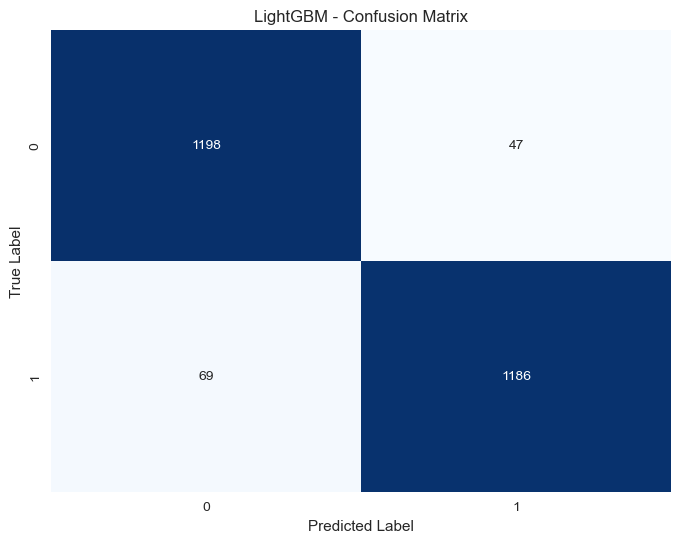

In [6]:
# Create and train LightGBM Classifier (sklearn API)
lgb_clf = LGBMClassifier(
    n_estimators=100,            # Number of trees
    learning_rate=0.1,           # Learning rate
    max_depth=5,                 # Maximum tree depth
    num_leaves=31,               # Maximum number of leaves in one tree
    min_child_samples=20,        # Minimum number of data needed in a leaf
    subsample=0.8,               # Subsample ratio of training instances
    colsample_bytree=0.8,        # Subsample ratio of columns for each tree
    reg_alpha=0.1,               # L1 regularization
    reg_lambda=0.1,              # L2 regularization
    random_state=42
)

# Train the model
start_time = time.time()
lgb_clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], eval_metric='binary_error')
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred = lgb_clf.predict(X_test)
y_prob = lgb_clf.predict_proba(X_test)[:, 1]  # Probability for class 1

# Evaluate the model
print("\n--- LightGBM Classification Results (sklearn API) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('LightGBM - Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

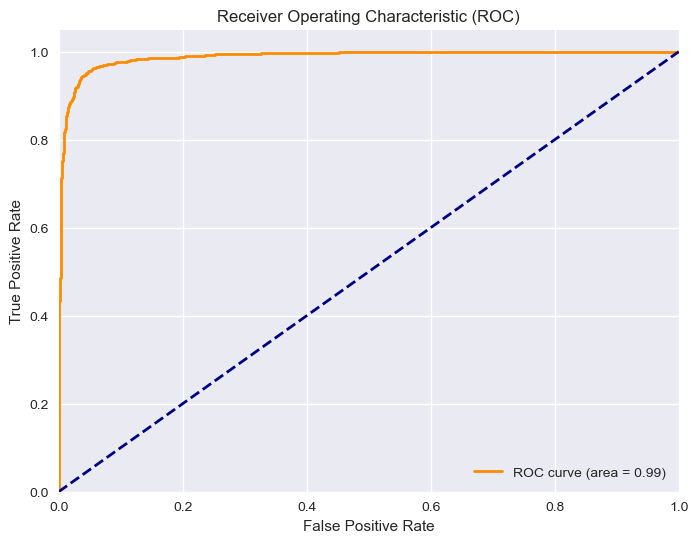

In [7]:
# Plot ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

### **5.2 Classification Example - Native LightGBM API**

The native API offers more flexibility and potentially better performance.

In [10]:
# Convert data to LightGBM Dataset format
train_data = lgb.Dataset(X_train, label=y_train)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# Set parameters
params = {
    'objective': 'binary',
    'metric': 'binary_error',
    'boosting': 'gbdt',           # Traditional Gradient Boosting Decision Tree
    'max_depth': 5,
    'num_leaves': 31,
    'learning_rate': 0.1,
    'feature_fraction': 0.8,      # Subsample ratio of columns
    'bagging_fraction': 0.8,      # Subsample ratio of rows
    'bagging_freq': 5,            # Perform bagging every k iterations
    'verbose': -1,                # Suppress printing
    'lambda_l1': 0.1,             # L1 regularization
    'lambda_l2': 0.1,             # L2 regularization
    'seed': 42
}

# Set up evaluation results storage
evals_result = {}

# Train the model using native API
start_time = time.time()
model = lgb.train(
    params,
    train_data,
    num_boost_round=100,
    valid_sets=[train_data, test_data],
    valid_names=['train', 'test'],
    callbacks=[
        lgb.early_stopping(20),
        lgb.record_evaluation(evals_result)
    ]
)
native_training_time = time.time() - start_time
print(f"Training time (native API): {native_training_time:.2f} seconds")

# Make predictions
y_pred_native = model.predict(X_test) > 0.5  # Threshold for binary classification
y_prob_native = model.predict(X_test)

# Evaluate the model
print("\n--- LightGBM Classification Results (Native API) ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred_native):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_native.astype(int)))

Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[99]	train's binary_error: 0.016	test's binary_error: 0.0488
Training time (native API): 0.47 seconds

--- LightGBM Classification Results (Native API) ---
Accuracy: 0.9512

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1245
           1       0.96      0.94      0.95      1255

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



<Figure size 1000x600 with 0 Axes>

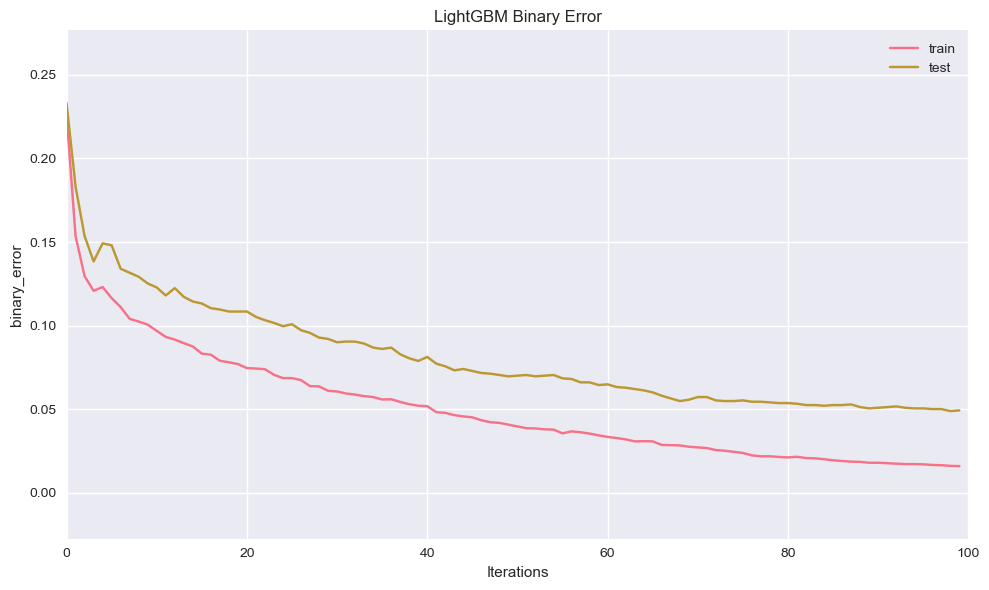

In [11]:
# Plot the training history from native API training
plt.figure(figsize=(10, 6))
ax = lgb.plot_metric(evals_result, metric='binary_error')
plt.title('LightGBM Binary Error')
plt.tight_layout()
plt.show()

### **5.3 Regression Example**

Training time: 0.40 seconds

--- LightGBM Regression Results ---
R² Score: 0.8884
Mean Squared  Error : 7384.85
Mean Absolute Error : 66.50


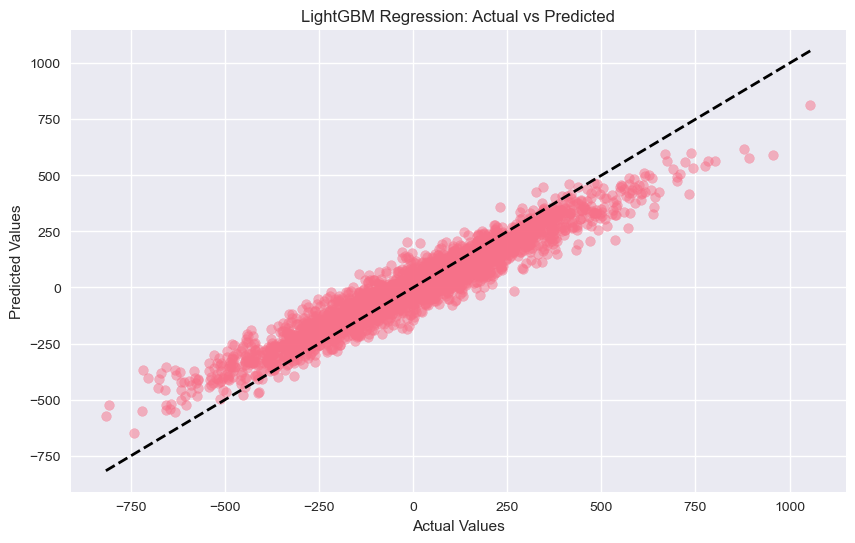

In [14]:
# Generate a synthetic regression dataset
X_reg, y_reg = make_regression(
    n_samples=10000, 
    n_features=50, 
    n_informative=20,
    noise=0.1,
    random_state=42
)

# Split the regression data
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.25, random_state=42)

# Create and train a LightGBM Regressor
lgb_reg = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Train the model
start_time = time.time()
lgb_reg.fit( X_train_reg,  y_train_reg,  eval_set=[(X_test_reg, y_test_reg)], eval_metric='rmse')
training_time = time.time() - start_time
print(f"Training time: {training_time:.2f} seconds")

# Make predictions
y_pred_reg = lgb_reg.predict(X_test_reg)

# Evaluate the model
print("\n--- LightGBM Regression Results ---")
print(f"R² Score: {r2_score(y_test_reg, y_pred_reg):.4f}")
print(f"Mean Squared  Error : {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"Mean Absolute Error : {mean_absolute_error(y_test_reg, y_pred_reg):.2f}")

# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test_reg, y_pred_reg, alpha=0.5)
plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=2)
plt.title('LightGBM Regression: Actual vs Predicted')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.show()

### **5.4 Working with Categorical Features**

One of LightGBM's strengths is its native handling of categorical features.

In [15]:
# Create a dataset with categorical features
np.random.seed(42)

# Generate numerical features
X_num = np.random.normal(size=(5000, 5))

# Generate categorical features
X_cat1 = np.random.randint(0, 10, size=5000)  # 10 categories
X_cat2 = np.random.randint(0, 5, size=5000)   # 5 categories
X_cat3 = np.random.randint(0, 20, size=5000)  # 20 categories

# Combine features
X_mixed = np.column_stack([X_num, X_cat1, X_cat2, X_cat3])

# Generate target (influenced by both numerical and categorical features)
y_mixed = (
    2*X_num[:, 0] + 
    0.5*X_num[:, 1] - 
    X_num[:, 2] + 
    0.5*(X_cat1 == 3) + 
    1.0*(X_cat2 == 1) -
    0.5*(X_cat3 == 10) + 
    np.random.normal(scale=0.5, size=5000)
).astype('float32')

# Convert to binary classification
y_mixed_binary = (y_mixed > y_mixed.mean()).astype(int)

# Create DataFrame for better handling
df_mixed = pd.DataFrame(
    X_mixed, 
    columns=['num1', 'num2', 'num3', 'num4', 'num5', 'cat1', 'cat2', 'cat3']
)
df_mixed['target'] = y_mixed_binary

# Convert categorical columns to the correct type
df_mixed['cat1'] = df_mixed['cat1'].astype('category')
df_mixed['cat2'] = df_mixed['cat2'].astype('category')
df_mixed['cat3'] = df_mixed['cat3'].astype('category')

print(df_mixed.info())
print("\nSample data:")
display(df_mixed.head())

# Split the data
X_mixed_train, X_mixed_test, y_mixed_train, y_mixed_test = train_test_split(df_mixed.drop('target', axis=1), df_mixed['target'], test_size=0.25, random_state=42)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   num1    5000 non-null   float64 
 1   num2    5000 non-null   float64 
 2   num3    5000 non-null   float64 
 3   num4    5000 non-null   float64 
 4   num5    5000 non-null   float64 
 5   cat1    5000 non-null   category
 6   cat2    5000 non-null   category
 7   cat3    5000 non-null   category
 8   target  5000 non-null   int64   
dtypes: category(3), float64(5), int64(1)
memory usage: 250.4 KB
None

Sample data:


,num1,num2,num3,num4,num5,cat1,cat2,cat3,target
0,0.496714,-0.138264,0.647689,1.523030,-0.234153,3.0,1.0,18.0,1
1,-0.234137,1.579213,0.767435,-0.469474,0.542560,2.0,3.0,1.0,0
2,-0.463418,-0.465730,0.241962,-1.913280,-1.724918,2.0,4.0,4.0,0
3,-0.562288,-1.012831,0.314247,-0.908024,-1.412304,9.0,4.0,0.0,0
4,1.465649,-0.225776,0.067528,-1.424748,-0.544383,3.0,0.0,13.0,1


--- LightGBM with Categorical Features ---
Accuracy: 0.9320

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.92      0.93       605
           1       0.93      0.94      0.93       645

    accuracy                           0.93      1250
   macro avg       0.93      0.93      0.93      1250
weighted avg       0.93      0.93      0.93      1250



<Figure size 1000x600 with 0 Axes>

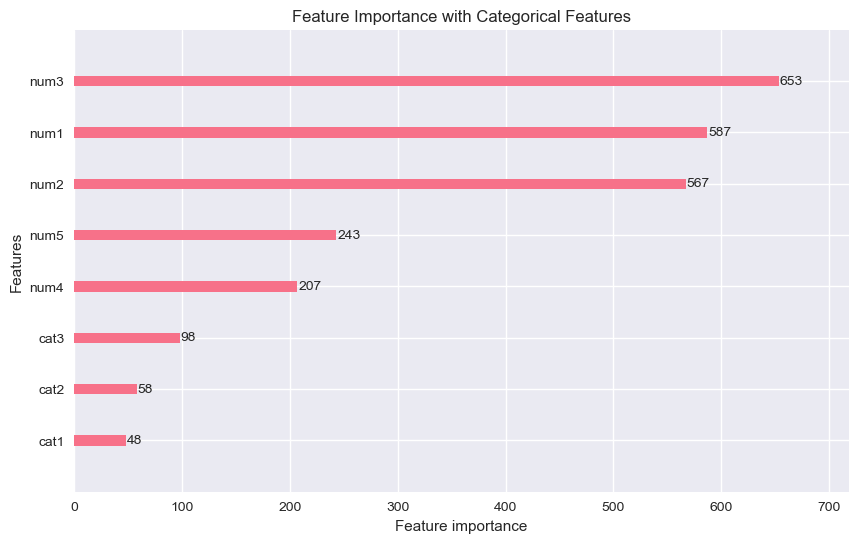

In [18]:
# Create LightGBM classifier with categorical feature support
lgb_cat = LGBMClassifier(n_estimators=100,learning_rate=0.1,max_depth=5,random_state=42)

# Identify categorical features
categorical_features = ['cat1', 'cat2', 'cat3']

# Train the model
lgb_cat.fit(X_mixed_train, y_mixed_train, eval_set=[(X_mixed_test, y_mixed_test)],eval_metric='binary_error',categorical_feature=categorical_features)

# Make predictions
y_pred_cat = lgb_cat.predict(X_mixed_test)

# Evaluate the model
print("--- LightGBM with Categorical Features ---")
print(f"Accuracy: {accuracy_score(y_mixed_test, y_pred_cat):.4f}")
print("\nClassification Report:")
print(classification_report(y_mixed_test, y_pred_cat))

# Display feature importance with categorical features
plt.figure(figsize=(10, 6))
lgb.plot_importance(lgb_cat, max_num_features=8)
plt.title('Feature Importance with Categorical Features')
plt.show()

## **🔍 6. Key Hyperparameters Explained**

LightGBM has numerous hyperparameters that control model behavior and performance. They can be divided into several categories:

### **Core Parameters**

| 📌 **Parameter** | 📝 **Description** | 🔧 **Typical Values** | 💡 **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **objective** | Task to perform | 'binary', 'regression', 'multiclass' | Depends on problem type |
| **boosting** | Boosting algorithm | 'gbdt', 'dart', 'goss', 'rf' | 'gbdt' is default, 'goss' is LightGBM-specific |
| **num_iterations / n_estimators** | Number of boosting iterations | 100-1000 | Higher values may improve performance |
| **learning_rate** | Shrinkage rate | 0.01-0.3 | Lower values need more iterations |

### **Learning Control Parameters**

| 📌 **Parameter** | 📝 **Description** | 🔧 **Typical Values** | 💡 **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **max_depth** | Maximum tree depth | 3-10 | Higher values = more complex model |
| **num_leaves** | Maximum number of leaves | 31-127 | Trade-off between accuracy and overfitting |
| **min_data_in_leaf / min_child_samples** | Minimum data in a leaf | 5-100 | Higher values prevent overfitting |
| **min_sum_hessian_in_leaf / min_child_weight** | Minimum sum of hessian in leaf | 1e-3-10 | Higher values = more conservative model |

### **Sampling Parameters**

| 📌 **Parameter** | 📝 **Description** | 🔧 **Typical Values** | 💡 **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **bagging_fraction / subsample** | Row sampling ratio | 0.5-1.0 | < 1.0 helps reduce overfitting |
| **bagging_freq** | Frequency for bagging | 0-10 | > 0 to enable bagging |
| **feature_fraction / colsample_bytree** | Column sampling ratio | 0.5-1.0 | < 1.0 prevents overfitting |

### **Regularization Parameters**

| 📌 **Parameter** | 📝 **Description** | 🔧 **Typical Values** | 💡 **Impact** |
| --------------- | ------------------ | -------------------- | ------------ |
| **lambda_l1 / reg_alpha** | L1 regularization | 0-1.0 | Higher values increase regularization |
| **lambda_l2 / reg_lambda** | L2 regularization | 0-1.0 | Higher values increase regularization |
| **max_delta_step** | Limits the maximum output of a leaf | 0-10 | Controls output range |

### **LightGBM-Specific Features**

- **Gradient-based One-Side Sampling (GOSS)**: Set `boosting='goss'` to enable
- **Categorical Features**: Use `categorical_feature` parameter to specify categorical columns
- **Monotonic Constraints**: Use `monotone_constraints` to enforce monotonicity
- **Early Stopping**: Set `early_stopping_rounds` to enable
- **Path Smoothing**: Set `path_smooth` to reduce variance in predictions

## **🔄 7. Hyperparameter Tuning**

In [19]:
# Define parameter grid for tuning
param_grid = {
    'n_estimators'      : [50, 100, 200],
    'learning_rate'     : [0.01, 0.1, 0.2],
    'max_depth'         : [-1, 5, 10],  # -1 means no limit
    'num_leaves'        : [31, 63, 127],
    'subsample'         : [0.6, 0.8, 1.0],
    'colsample_bytree'  : [0.6, 0.8, 1.0],
    'reg_alpha'         : [0, 0.1, 0.5],
    'reg_lambda'        : [0, 0.1, 0.5]
}

# Using RandomizedSearchCV to speed up the process
random_search = RandomizedSearchCV(estimator=LGBMClassifier(random_state=42),param_distributions=param_grid,n_iter=20, cv=5,scoring='accuracy',random_state=42,n_jobs=-1,verbose=1)

# Fit the randomized search
print("Starting randomized search...")
random_search.fit(X_train, y_train)

# Display best parameters and score
print(f"Best parameters: {random_search.best_params_}")
print(f"Best cross-validation score: {random_search.best_score_:.4f}")

# Create a model with the best parameters
best_lgb = random_search.best_estimator_

# Evaluate on the test set
best_predictions = best_lgb.predict(X_test)
print(f"Test accuracy with best parameters: {accuracy_score(y_test, best_predictions):.4f}")

Starting randomized search...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alpha': 0.1, 'num_leaves': 127, 'n_estimators': 200, 'max_depth': -1, 'learning_rate': 0.1, 'colsample_bytree': 1.0}
Best cross-validation score: 0.9624
Test accuracy with best parameters: 0.9728


## **📊 8. Feature Importance Visualization**

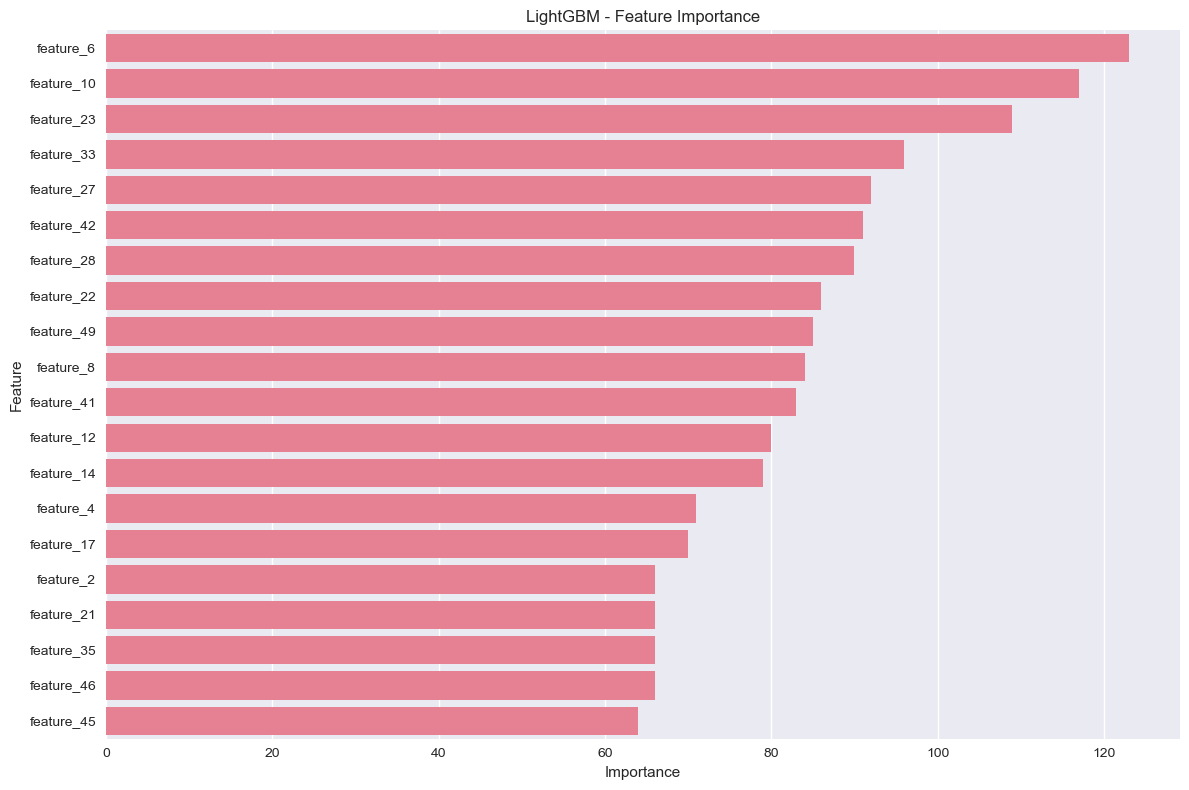

Top 10 Most Important Features:


,Feature,Importance
6,feature_6,123
10,feature_10,117
23,feature_23,109
33,feature_33,96
27,feature_27,92
42,feature_42,91
28,feature_28,90
22,feature_22,86
49,feature_49,85
8,feature_8,84


In [20]:
# Get feature importances from the trained model
feature_importances = lgb_clf.feature_importances_

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort by importance
importance_df = importance_df.sort_values('Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))  # Top 20 features
plt.title('LightGBM - Feature Importance')
plt.tight_layout()
plt.show()

# Print top 10 features
print("Top 10 Most Important Features:")
display(importance_df.head(10))

<Figure size 1200x800 with 0 Axes>

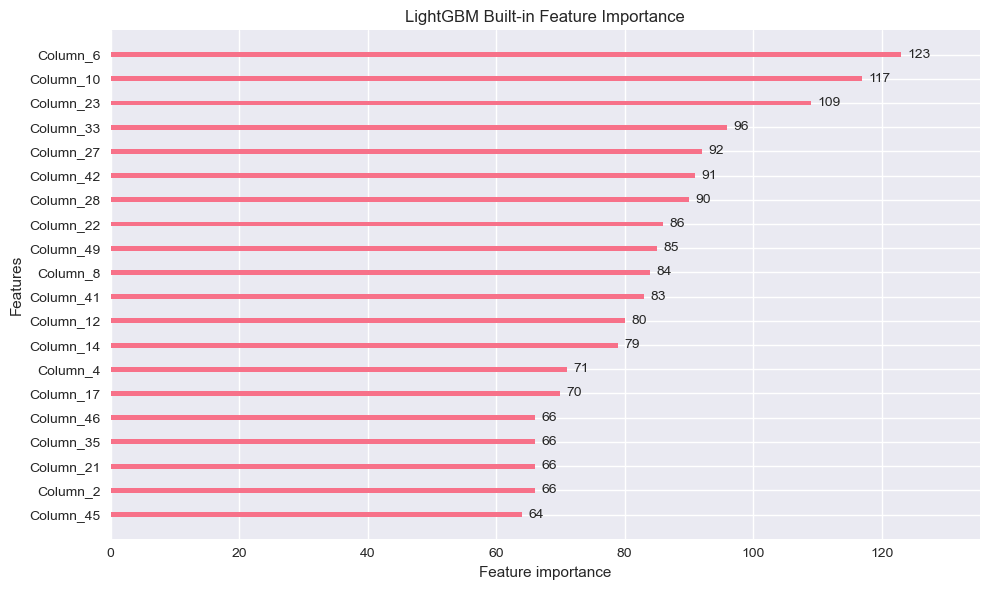

In [21]:
# LightGBM also provides built-in visualization functions
plt.figure(figsize=(12, 8))
lgb.plot_importance(lgb_clf, max_num_features=20)
plt.title('LightGBM Built-in Feature Importance')
plt.tight_layout()
plt.show()

## **🔄 9. Comparison with XGBoost**

Let's compare LightGBM with XGBoost on the same dataset.

--- Model Comparison ---
LightGBM Accuracy: 0.9492
XGBoost  Accuracy: 0.9492
Difference: 0.0000

LightGBM Training Time: 0.27 seconds
XGBoost  Training Time: 0.62 seconds
Speed Improvement: 2.28x faster


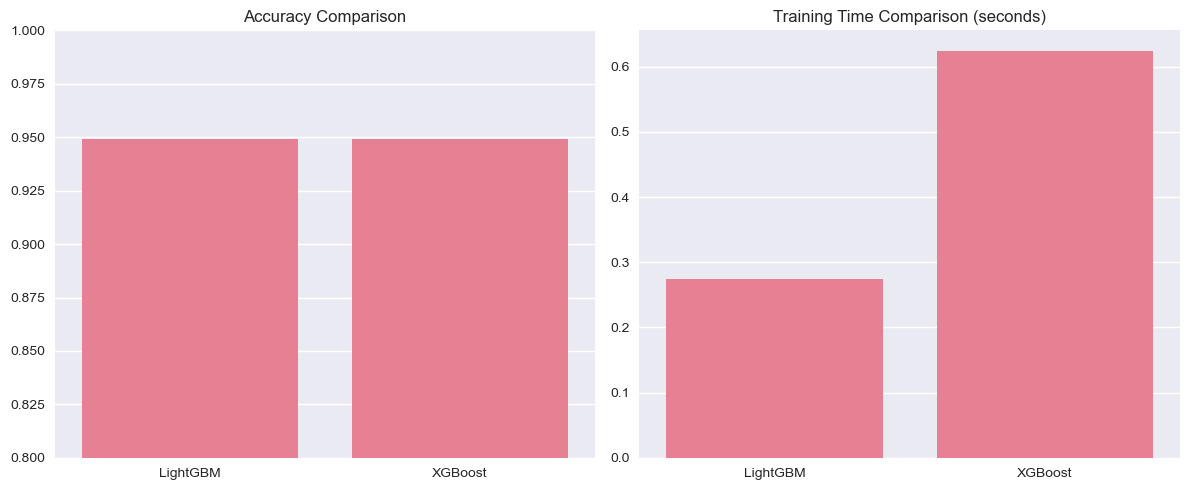

In [22]:
# Create and train an XGBoost model for comparison
xgb_clf = XGBClassifier(n_estimators=100,learning_rate=0.1,max_depth=5,subsample=0.8,colsample_bytree=0.8,random_state=42)

# Train both models and measure time
# LightGBM
start_time = time.time()
lgb_clf_comp = LGBMClassifier(n_estimators=100, max_depth=5, random_state=42)
lgb_clf_comp.fit(X_train, y_train)
lgb_time = time.time() - start_time
lgb_pred = lgb_clf_comp.predict(X_test)
lgb_acc  = accuracy_score(y_test, lgb_pred)

# XGBoost
start_time = time.time()
xgb_clf.fit(X_train, y_train)
xgb_time = time.time() - start_time
xgb_pred = xgb_clf.predict(X_test)
xgb_acc  = accuracy_score(y_test, xgb_pred)

# Compare results
print("--- Model Comparison ---")
print(f"LightGBM Accuracy: {lgb_acc:.4f}")
print(f"XGBoost  Accuracy: {xgb_acc:.4f}")
print(f"Difference: {abs(lgb_acc - xgb_acc):.4f}")
print(f"\nLightGBM Training Time: {lgb_time:.2f} seconds")
print(f"XGBoost  Training Time: {xgb_time:.2f} seconds")
print(f"Speed Improvement: {(xgb_time / lgb_time):.2f}x faster")

# Visualize comparison
plt.figure(figsize=(12, 5))
models = ['LightGBM', 'XGBoost']
accuracies = [lgb_acc, xgb_acc]
training_times = [lgb_time, xgb_time]

# Plot accuracy comparison
plt.subplot(1, 2, 1)
sns.barplot(x=models, y=accuracies)
plt.title('Accuracy Comparison')
plt.ylim(0.8, 1.0)  # Adjust as needed

# Plot training time comparison
plt.subplot(1, 2, 2)
sns.barplot(x=models, y=training_times)
plt.title('Training Time Comparison (seconds)')

plt.tight_layout()
plt.show()

## **🔍 10. Special LightGBM Features**

### **10.1 Gradient-based One-Side Sampling (GOSS)**

In [23]:
# Train a model with GOSS enabled
lgb_goss = LGBMClassifier(n_estimators=100,learning_rate=0.1,boosting_type='goss',max_depth=5,random_state=42)

# Train the model
start_time = time.time()
lgb_goss.fit(X_train, y_train)
goss_time = time.time() - start_time

# Make predictions
goss_pred = lgb_goss.predict(X_test)
goss_acc = accuracy_score(y_test, goss_pred)

print(f"GOSS Training Time : {goss_time:.2f} seconds")
print(f"GOSS Accuracy      : {goss_acc:.2f}")

GOSS Training Time : 0.28 seconds
GOSS Accuracy      : 0.96


## **💡 11. Best Practices and Tips**

### **When to Choose LightGBM**

- **For large datasets**: LightGBM shines on datasets with millions of rows
- **When speed matters**: Significantly faster than traditional GBM algorithms
- **For high-dimensional data**: Handles many features efficiently
- **When using categorical features**: Native support without one-hot encoding
- **For distributed training**: Well-designed for parallel and distributed settings
- **When memory is limited**: More memory-efficient than alternatives

### **Tuning Strategy**

1. **Start with proper settings to prevent overfitting**:

   a. **For small datasets**:
      - `num_leaves`: Small value (< 31)
      - `min_data_in_leaf`: 20 or higher
      - `max_depth`: Constrain tree depth (3-7)

   b. **Control model complexity**:
      - `max_depth` and `num_leaves`: Key parameters (num_leaves < 2^max_depth)
      - `min_data_in_leaf`: Prevents creating too specialized leaves
   
   c. **Use sampling techniques**:
      - `feature_fraction` (0.5-0.8)
      - `bagging_fraction` (0.5-0.8) with `bagging_freq` > 0
   
   d. **Add regularization**:
      - `lambda_l1` and `lambda_l2` (0.01-0.1)
   
2. **For even better performance**:
   - Try different `boosting_type` values ('gbdt', 'dart', 'goss')
   - Use early stopping to find optimal `n_estimators`
   - Tune `learning_rate` after other parameters (0.01-0.1)

### **Practical Advice**

- **For categorical features**: Use LightGBM's native handling instead of one-hot encoding
- **For large datasets**: Use GOSS boosting type for better sampling efficiency
- **For unbalanced classes**: Set `is_unbalance=True` or adjust `scale_pos_weight`
- **For memory efficiency**: Use `categorical_feature` parameter instead of creating dummy variables
- **For faster speed**: Enable `histogram_pool_size` to cache histograms
- **For GPU usage**: Set `device='gpu'` for GPU acceleration

### **Common Pitfalls**

- **Overfitting with leaf-wise growth**: Always constrain `num_leaves` and/or `max_depth`
- **Setting num_leaves too high**: Should be much smaller than 2^max_depth
- **Ignoring min_data_in_leaf**: Critical parameter especially for small datasets
- **Not specifying categorical features**: LightGBM needs to know which features are categorical
- **Training too deep trees**: Leaf-wise growth creates deep trees quickly; control depth
- **Using GOSS for small datasets**: GOSS works best with large datasets

## **🔄 12. Comparison with Other Boosting Algorithms**

| Algorithm | Strengths | Weaknesses | Best Use Case |
|-----------|-----------|------------|---------------|
| **LightGBM** | Very fast, memory efficient, native categorical support | Requires more tuning to prevent overfitting | Large datasets, speed-critical applications |
| **XGBoost** | Robust, all-around performer, regularization | Slower, higher memory usage | General problems, smaller datasets |
| **CatBoost** | Best handling of categorical features, minimal tuning | Can be slower than LightGBM | Datasets with many categorical features |
| **Sklearn GBM** | Simple interface | Much slower, less optimized | Learning gradient boosting concepts |

## **📚 13. Additional Resources**

### **Official Documentation**

- [LightGBM Documentation](https://lightgbm.readthedocs.io/)
- [Parameters Tuning Guide](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)
- [Advanced Features](https://lightgbm.readthedocs.io/en/latest/Advanced-Topics.html)

### **Papers and Articles**

- [LightGBM: A Highly Efficient Gradient Boosting Decision Tree](https://papers.nips.cc/paper/6907-lightgbm-a-highly-efficient-gradient-boosting-decision-tree.pdf) - Original paper
- [LightGBM: An effective and scalable algorithm for prediction tasks](https://www.sciencedirect.com/science/article/pii/S2666651021000012)

### **Tutorials and Guides**

- [Complete Guide to Parameter Tuning in LightGBM](https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/)
- [LightGBM vs XGBoost](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc)

---

<h3 align="center">⚡ Happy Modeling with LightGBM! ⚡</h3>